# Twitter Sentiment Analysis with LSTM

The goal of this notebook is to use deep learning to analyze the sentiment of a tweet dataset avaliable on Kaggle. In particular, LSTM (Long Short Term Memory) will be used.

GitHub: https://github.com/tkdev001/lstm_tweet_sentiment

## Environment Setup, EDA and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import emoji
import re
#import nltk
#nltk.download("wordnet")
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords, wordnet
!pip install contractions
import contractions
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.9 MB/s eta 0:00:00


### Import data

[Twitter Tweets Sentiment Dataset](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset?datasetId=2066095) will be used.

The dataset consists of 27481 rows and 4 columns:
- `textID`: unique ID for each piece of text
- `text`: the text of the tweet
- `selected_text`: word or phrase drawn from the tweet that encapsulates the provided sentiment
- `sentiment`: the general sentiment of the tweet

Only `text` and `sentiment` will be used.

In [2]:
data = pd.read_csv("/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv")
data.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [3]:
data = data[["text", "sentiment"]]
data = (data.dropna()
            .drop_duplicates())
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


After dropping NAs and duplicates, there are **27480** rows in the dataset.

[Text(0, 0, '7781'), Text(0, 0, '11117'), Text(0, 0, '8582')]

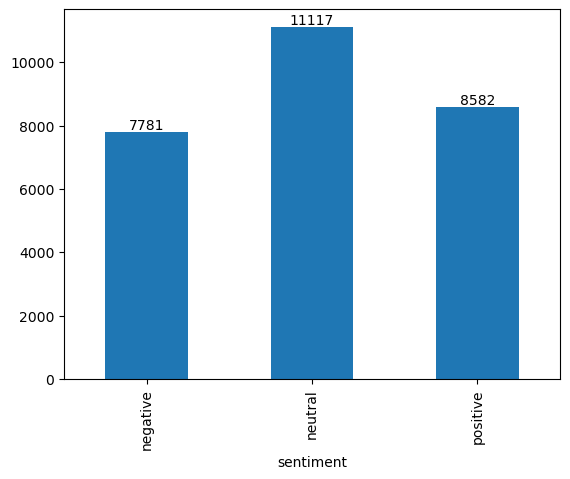

In [4]:
p = data.groupby("sentiment")["sentiment"].count().plot(kind="bar")
p.bar_label(p.containers[0])

### Word count distribution

In [5]:
word_len_neg = data[data["sentiment"]=="negative"]["text"].str.split().map(lambda x : len(x))
word_len_neu = data[data["sentiment"]=="neutral"]["text"].str.split().map(lambda x : len(x))
word_len_pos = data[data["sentiment"]=="positive"]["text"].str.split().map(lambda x : len(x))

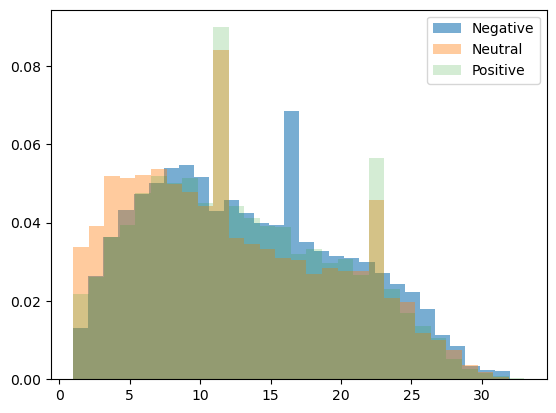

In [6]:
plt.hist(word_len_neg, 29, density=True, alpha=0.6, label="Negative")
plt.hist(word_len_neu, 29, density=True, alpha=0.4, label="Neutral")
plt.hist(word_len_pos, 29, density=True, alpha=0.2, label="Positive")
plt.legend(loc="upper right")
plt.show()

The 3 types of tweets have a similar word count distribution.

### Text pre-processing

Below clean-up actions will be applyed on the tweets.

- Convert to lowercase
- Remove emojis
- Remove URLs
- Remove mentions
- Remove digits
- Fix contractions
- Remove punctuations

After performing some testing, it seems that lemmatization and removing stopwords does not increase the classification accuracy, so these steps will be skipped.

In [7]:
#lemmatizer = WordNetLemmatizer()

def clean_text(text):
    result = text.lower()
    result = emoji.replace_emoji(result, replace="")
    result = re.sub(r"https?://\S+|www\.\S+|http?://\S+", "", result)
    result = re.sub(r"@\S+", "", result)
    result = re.sub(r"[0-9]", "", result)
    result = re.sub(r"|û|ò|ª|è|ñ", "", result)
    result = result.replace("`","'")
    result = contractions.fix(result)
    result = result.translate(str.maketrans("", "", string.punctuation))
    
    result = result.split()
    result = [word for word in result if
              word != "rt" and
              word != "amp"]
    #result = [lemmatizer.lemmatize(word) for word in result if word not in stopwords.words("english")]
    #result = [lemmatizer.lemmatize(word) for word in result]
    #result = [word for word in result if len(word) > 1]
    
    return " ".join(result)

In [8]:
data["clean_text"] = data["text"].apply(clean_text)
data = data[["text", "clean_text", "sentiment"]].drop_duplicates()
data.head()

,text,clean_text,sentiment
0,"I`d have responded, if I were going",i would have responded if i were going,neutral
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad i will miss you here in san diego,negative
2,my boss is bullying me...,my boss is bullying me,negative
3,what interview! leave me alone,what interview leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",sons of why could not they put them on the rel...,negative


In [9]:
temp = set()
data["clean_text"].str.split().apply(temp.update)
vocab_size_full = len(temp)
print(f"Distinct word count of clean_text: {vocab_size_full}")

Distinct word count of clean_text: 26576


### Word cloud after text pre-processing

In [10]:
def wordcloud(data, title):
    words = " ".join(data["clean_text"].astype("str").tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=1024, height=512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

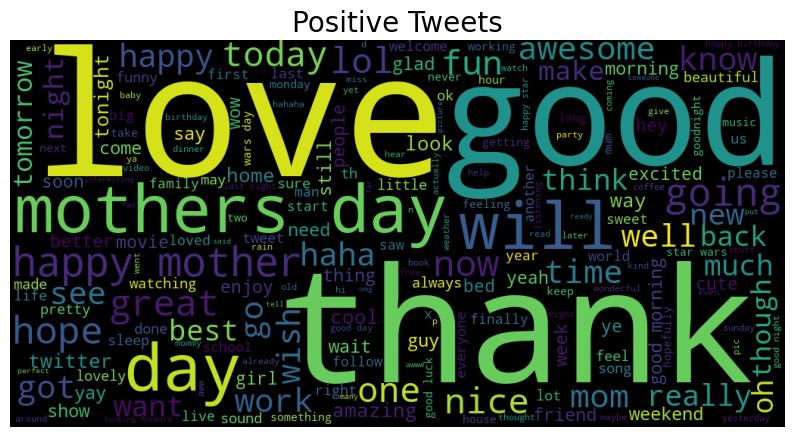

In [11]:
wordcloud(data[data["sentiment"] == "positive"], "Positive Tweets")

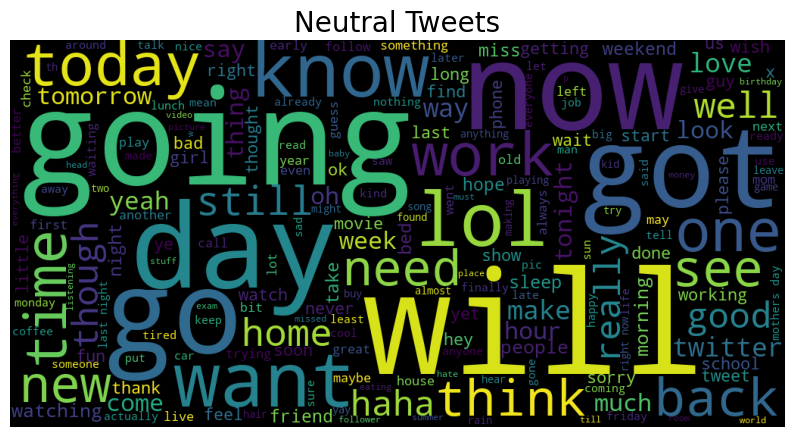

In [12]:
wordcloud(data[data["sentiment"] == "neutral"], "Neutral Tweets")

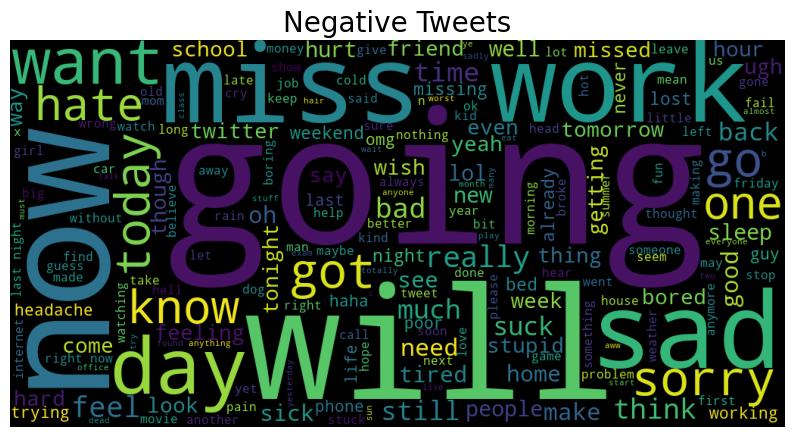

In [13]:
wordcloud(data[data["sentiment"] == "negative"], "Negative Tweets")

### Tokenize the text

In [14]:
tokenizer = Tokenizer(num_words=vocab_size_full)
tokenizer.fit_on_texts(data["clean_text"])
sequences = tokenizer.texts_to_sequences(data["clean_text"])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

text_pad_seq = pad_sequences(sequences, padding="post")

sent_label = {"negative": 0,
              "neutral": 1,
              "positive": 2}
data["label"] = data["sentiment"].map(sent_label)
labels = to_categorical(data["label"], num_classes=3)

print(f"Shape of input: {text_pad_seq.shape}")
print(f"Shape of label: {labels.shape}")

MAX_SEQUENCE_LENGTH = text_pad_seq.shape[1]

Found 26576 unique tokens.
Shape of input: (27480, 35)
Shape of label: (27480, 3)


### Split the dataset into train and test set

Split with a 8:2 ratio.

In [15]:
seed = 100
x_train, x_test, y_train, y_test = train_test_split(text_pad_seq, 
                                                    labels, test_size=0.2, random_state=seed)
print(f"train: {x_train.shape[0]}. test: {x_test.shape[0]}")

train: 21984. test: 5496


## Model Building & Training

### Word embedding

GloVe (Global Vectors for Word Representation) will be used for word embedding. GloVe is a type of word embedding model that is commonly used in natural language processing and text analysis. It is designed to capture the meaning of words by representing them as dense, low-dimensional vectors. The key idea behind GloVe is to leverage the co-occurrence statistics of words in a large corpus of text to learn the word embeddings. The basic assumption is that words that co-occur frequently in the same context tend to have similar meanings. The GloVe model constructs a global word-word co-occurrence matrix from the corpus, which captures the frequency of each word's co-occurrence with every other word in the corpus. It then factorizes this matrix using singular value decomposition (SVD) to obtain the word embeddings.

[Pre-trained GloVe models](https://www.kaggle.com/datasets/anindya2906/glove6b) with 50, 100, 200, 300 features are available. The one with 100 features will be used.

In [16]:
embeddings_index = {}
with open("/kaggle/input/glove6b/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
        
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [17]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM model

First, let's build and train a vanilla LSTM model.

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is commonly used in deep learning for sequential data modeling. It is designed to address the exploding/vanishing gradient problem in traditional RNNs, which occurs when gradients become too large/small as they propagate through the network, making it difficult to learn long-term dependencies in sequential data.

In [18]:
model_lstm = Sequential(name="model_lstm")

model_lstm.add(Embedding(len(word_index)+1,
                         EMBEDDING_DIM,
                         weights=[embedding_matrix],
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=False))
model_lstm.add(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(GlobalMaxPool1D())
model_lstm.add(Dense(64, activation="relu"))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(3, activation="softmax"))

model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           2657700   
                                                                 
 lstm (LSTM)                 (None, 35, 100)           80400     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [19]:
learning_rate = 0.001
epochs = 20

early_stop = EarlyStopping(monitor="val_accuracy", patience=3)

model_lstm.compile(optimizer=Adam(learning_rate=learning_rate), 
                   loss="categorical_crossentropy", metrics=["accuracy"])
hist_lstm = model_lstm.fit(x_train, y_train, epochs=epochs, 
                           validation_split=0.2, callbacks=early_stop)

Epoch 1/20
550/550 [==============================] - 30s 49ms/step - loss: 0.9089 - accuracy: 0.5673 - val_loss: 0.7427 - val_accuracy: 0.6889
Epoch 2/20
550/550 [==============================] - 26s 48ms/step - loss: 0.7680 - accuracy: 0.6740 - val_loss: 0.6970 - val_accuracy: 0.7059
Epoch 3/20
550/550 [==============================] - 26s 48ms/step - loss: 0.7258 - accuracy: 0.6926 - val_loss: 0.6687 - val_accuracy: 0.7114
Epoch 4/20
550/550 [==============================] - 26s 48ms/step - loss: 0.7034 - accuracy: 0.7024 - val_loss: 0.6594 - val_accuracy: 0.7232
Epoch 5/20
550/550 [==============================] - 26s 48ms/step - loss: 0.6841 - accuracy: 0.7131 - val_loss: 0.6509 - val_accuracy: 0.7266
Epoch 6/20
550/550 [==============================] - 26s 48ms/step - loss: 0.6673 - accuracy: 0.7202 - val_loss: 0.6340 - val_accuracy: 0.7373
Epoch 7/20
550/550 [==============================] - 27s 48ms/step - loss: 0.6495 - accuracy: 0.7314 - val_loss: 0.6382 - val_accuracy:

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    
    plt.title("Model Evaluation")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    
    plt.show()

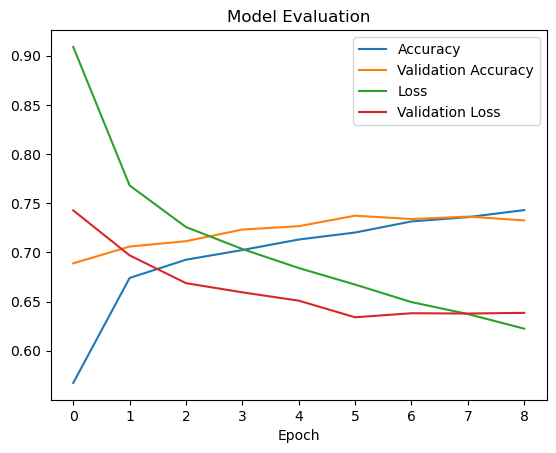

In [21]:
plot_hist(hist_lstm)

### Bidirectional LSTM model

Next, let's try to build a bidirectional LSTM model and see if there is any gain in performance.

The key difference between LSTM and bidirectional LSTM lies in the direction of the information flow. In a regular LSTM, information flows only from past to future, and the cell state and hidden state are updated based on the past information. In contrast, bidirectional LSTMs process the sequence both forward and backward, allowing them to capture information from both past and future contexts. This means that bidirectional LSTMs have access to both the past and future context of a given point in the sequence, which can be beneficial in certain tasks such as machine translation or speech recognition.

In [22]:
model_bilstm = Sequential(name="model_bilstm")

model_bilstm.add(Embedding(len(word_index)+1,
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False))
model_bilstm.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model_bilstm.add(GlobalMaxPool1D())
model_bilstm.add(Dense(64, activation="relu"))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Dense(3, activation="softmax"))

model_bilstm.summary()

Model: "model_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           2657700   
                                                                 
 bidirectional (Bidirectiona  (None, 35, 200)          160800    
 l)                                                              
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                12864     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [23]:
model_bilstm.compile(optimizer=Adam(learning_rate=learning_rate), 
                     loss="categorical_crossentropy", metrics=["accuracy"])
hist_bilstm = model_bilstm.fit(x_train, y_train, epochs=epochs, 
                               validation_split=0.2, callbacks=early_stop)

Epoch 1/20
550/550 [==============================] - 53s 87ms/step - loss: 0.8931 - accuracy: 0.5891 - val_loss: 0.7172 - val_accuracy: 0.6987
Epoch 2/20
550/550 [==============================] - 47s 85ms/step - loss: 0.7512 - accuracy: 0.6801 - val_loss: 0.6808 - val_accuracy: 0.7078
Epoch 3/20
550/550 [==============================] - 48s 87ms/step - loss: 0.7147 - accuracy: 0.7011 - val_loss: 0.6657 - val_accuracy: 0.7139
Epoch 4/20
550/550 [==============================] - 47s 85ms/step - loss: 0.6882 - accuracy: 0.7092 - val_loss: 0.6557 - val_accuracy: 0.7189
Epoch 5/20
550/550 [==============================] - 47s 86ms/step - loss: 0.6692 - accuracy: 0.7191 - val_loss: 0.6346 - val_accuracy: 0.7330
Epoch 6/20
550/550 [==============================] - 47s 86ms/step - loss: 0.6452 - accuracy: 0.7311 - val_loss: 0.6323 - val_accuracy: 0.7335
Epoch 7/20
550/550 [==============================] - 47s 86ms/step - loss: 0.6281 - accuracy: 0.7416 - val_loss: 0.6354 - val_accuracy:

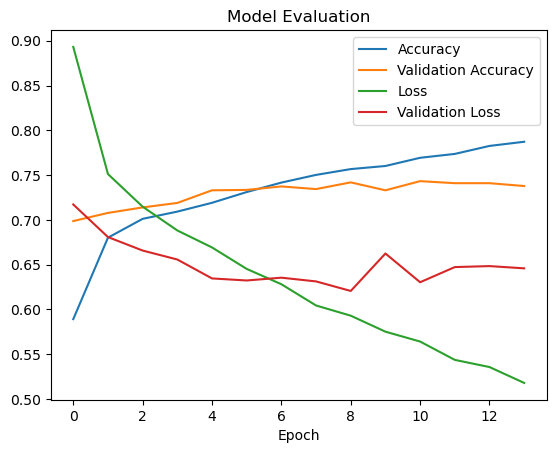

In [24]:
plot_hist(hist_bilstm)

### Model & hyperparameter tuning

Let's try to adjust the model structure and hyperparameters and see how the accuracy changes. Below is an updated bidirectional LSTM model with an additional LSTM layer. The dropout rate of the dense layer has also been increased slightly. The model will be trained with a higher learning rate of 0.004.

In [31]:
model_bilstm2 = Sequential(name="model_bilstm2")

model_bilstm2.add(Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model_bilstm2.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model_bilstm2.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model_bilstm2.add(Dense(64, activation="relu"))
model_bilstm2.add(Dropout(0.4))
model_bilstm2.add(Dense(3, activation="softmax"))

model_bilstm2.summary()

Model: "model_bilstm2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 100)           2657700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 35, 200)          160800    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)               

In [32]:
learning_rate = 0.004

model_bilstm2.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss="categorical_crossentropy", metrics=["accuracy"])
hist_bilstm2 = model_bilstm2.fit(x_train, y_train, epochs=epochs, 
                                 validation_split=0.2, callbacks=early_stop)

Epoch 1/20
550/550 [==============================] - 99s 159ms/step - loss: 0.8768 - accuracy: 0.6007 - val_loss: 0.7296 - val_accuracy: 0.6900
Epoch 2/20
550/550 [==============================] - 86s 157ms/step - loss: 0.7355 - accuracy: 0.6951 - val_loss: 0.6580 - val_accuracy: 0.7275
Epoch 3/20
550/550 [==============================] - 86s 157ms/step - loss: 0.6877 - accuracy: 0.7183 - val_loss: 0.6266 - val_accuracy: 0.7451
Epoch 4/20
550/550 [==============================] - 88s 159ms/step - loss: 0.6641 - accuracy: 0.7269 - val_loss: 0.6213 - val_accuracy: 0.7432
Epoch 5/20
550/550 [==============================] - 87s 158ms/step - loss: 0.6341 - accuracy: 0.7467 - val_loss: 0.6159 - val_accuracy: 0.7526
Epoch 6/20
550/550 [==============================] - 87s 158ms/step - loss: 0.6176 - accuracy: 0.7562 - val_loss: 0.6232 - val_accuracy: 0.7407
Epoch 7/20
550/550 [==============================] - 86s 156ms/step - loss: 0.5992 - accuracy: 0.7581 - val_loss: 0.6208 - val_ac

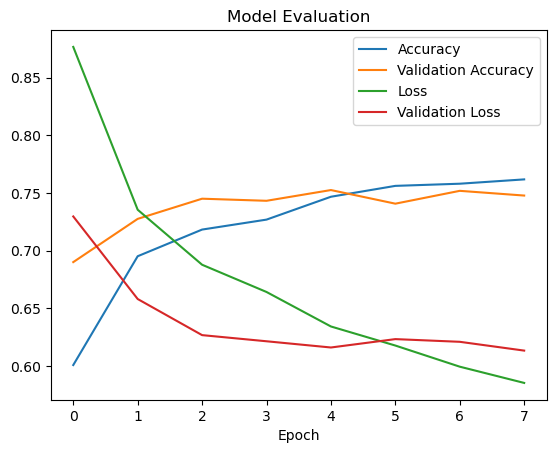

In [33]:
plot_hist(hist_bilstm2)

### Testing

Let's apply the models on the test set and see how they perform.

In [34]:
pred_class_lstm = np.argmax(model_lstm.predict(x_test), axis=1)
pred_class_bilstm = np.argmax(model_bilstm.predict(x_test), axis=1)
pred_class_bilstm2 = np.argmax(model_bilstm2.predict(x_test), axis=1)
y_test_class = np.argmax(y_test, axis=1)

172/172 [==============================] - 5s 23ms/step


In [35]:
print(f"Test accuracy (model_lstm): {accuracy_score(y_test_class, pred_class_lstm)}")
print(f"Test accuracy (model_bilstm): {accuracy_score(y_test_class, pred_class_bilstm)}")
print(f"Test accuracy (model_bilstm2): {accuracy_score(y_test_class, pred_class_bilstm2)}")

Test accuracy (model_lstm): 0.7421761280931587
Test accuracy (model_bilstm): 0.7412663755458515
Test accuracy (model_bilstm2): 0.7503639010189228


In [36]:
print(confusion_matrix(y_test_class, pred_class_lstm))
print(confusion_matrix(y_test_class, pred_class_bilstm))
print(confusion_matrix(y_test_class, pred_class_bilstm2))

[[1200  310   57]
 [ 405 1614  220]
 [ 116  309 1265]]
[[1041  445   81]
 [ 247 1679  313]
 [  44  292 1354]]
[[1115  406   46]
 [ 291 1700  248]
 [  51  330 1309]]


## Discussion & Conclusion

| Final accuracy | Validation | Testing |
| --- | --- | --- | 
| LSTM | 0.7325 | 0.7422 |
| Bidirectional LSTM | 0.7378 | 0.7413 |
| Bidirectional LSTM (tuned) | **0.7478** | **0.7504** |

- All models perform similarly, with accuracy around 0.73 - 0.75
- For this case, bidirectional LSTM performs almost the same as regular LSTM
- After tuning, the bidirectional LSTM model performs slightly better
- Training time per epoch increased when the model became more complex

Some potential ways to improve the performance:
- More extensive model/hyperparameter tuning
- Try out other word embedding methods